In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/ToyVortex.jl/")

  Activating environment at `/media/mat/HDD/ToyVortex.jl/Project.toml`


In [2]:
using Revise
using ToyVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions

In [3]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)
pyplot()
using LaTeXStrings
using StatsPlots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1342
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** i

### Routines for the plots

In [4]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config.zs, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 15), 
                      ylim = (-1.2*maximum(imag.(config.zs)), 1.2maximum(imag.(config.zs))); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [5]:
#
Δtgif = 0.1

# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset, Ns = 0, zs = [2.0*im], Qs = [0.0], U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4, ϵQ = 1e-6,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
end

Nv = config_data.Nv
Ns = config_data.Ns

xgrid = range(-3, 15, length=100)
ygrid = range(-1.2*maximum(imag.(config_data.zs)), 1.2*maximum(imag.(config_data.zs)), length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

### Generate the truth used in the twin experiment

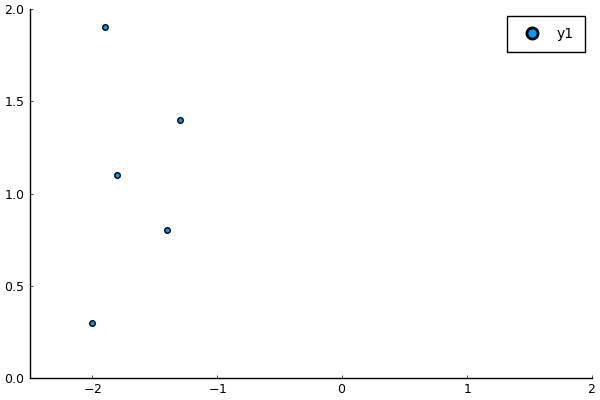

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


In [6]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [7]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

source₊ = Ns >0 ? map(Source.Blob, config_data.zs, config_data.Qs, config_data.δ*ones(Ns)) : PotentialFlow.Blobs.Blob{ComplexF64, Float64}[]
source₋ = Ns >0 ? map(Source.Blob, conj.(config_data.zs), config_data.Qs, config_data.δ*ones(Ns)) : PotentialFlow.Blobs.Blob{ComplexF64, Float64}[]

sys = (vcat(blobs₊, blobs₋),  vcat(source₊, source₋...))

# data = generate_vortex(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/ToyVortex.jl/src/data/");
tt, x0, xt, yt = load("/media/mat/HDD/ToyVortex.jl/src/data/data_vortex_source.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  11.991, 11.992, 11.993, 11.994, 11.995000000000001, 11.996, 11.997, 11.998000000000001, 11.999, 12.0], [-2.018587306805637, 0.3469573514039377, 0.45880001794294045, -1.8218225076346501, 1.8957320291019035, 0.3768744289098014, -1.8102180547912552, 1.0615219698346763, 0.26918155979815017, -1.273480600181778, 1.3996292681183138, 0.39099049767578464, -1.3586001809001103, 0.7834839950529129, 0.2327616928563841], [-2.018587306805637 -2.0172169502893196 … 12.59044061465947 12.591482987090947; 0.3469573514039377 0.3469042736866317 … 1.1421505993204804 1.1421716017979275; … ; 0.7834839950529129 0.7835958875071971 … 1.5055566951364918 1.5054079889283538; 0.2327616928563841 0.2327616928563841 … 0.2327616928563841 0.2327616928563841], [-0.524522656873511 -0.5090575008179341 … -0.4727590518054783 -0.4724508529842126; -0.5379397508961893 -0.5208171476572888 … -0.5119750022574816 -0.5141480271955431; 

In [8]:
x0

15-element Vector{Float64}:
 -2.018587306805637
  0.3469573514039377
  0.45880001794294045
 -1.8218225076346501
  1.8957320291019035
  0.3768744289098014
 -1.8102180547912552
  1.0615219698346763
  0.26918155979815017
 -1.273480600181778
  1.3996292681183138
  0.39099049767578464
 -1.3586001809001103
  0.7834839950529129
  0.2327616928563841

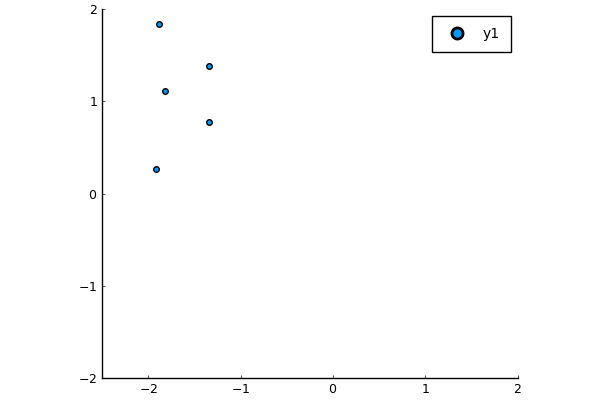

In [9]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

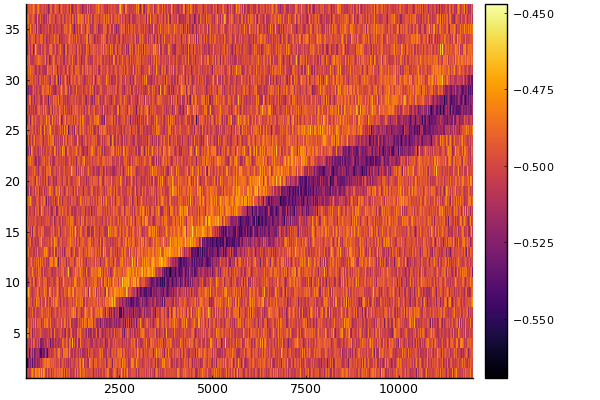

findfont: Font family ['Computer Modern'] not found. Falling back to DejaVu Sans.


In [10]:
heatmap(data.yt)

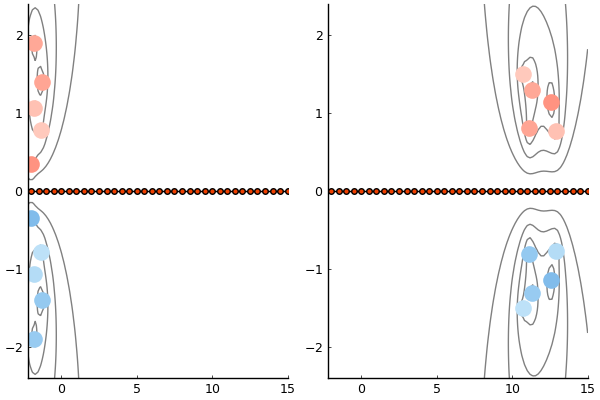

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [11]:
plt1 = routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

plot(plt1, plt2)

In [12]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config_data.Δt)+1
#     plt1 = routine_plot(data.xt[:,nsnap], config_data, xgrid, ygrid; withvortices = true)
#     plt2 = plot(real(config_data.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config_data), xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), color = :teal, legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot(plt1, plt2)
# #     next!(prog)
# end

### Setup the sequential filter

In [13]:
# config = let Nv = Nclusters*Nset, Ns = 1, zs = [2.0*im], Qs = [1.0], U = complex(1.0), 
#              ss = sensors, Δt = 1e-2, δ = 1e-2,
#              ϵX = 5e-3, ϵΓ = 5e-3, ϵQ = 5e-3,
#              β = 1.0,
#              ϵY = 1e-2
#     VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
# end

config = deepcopy(config_data)

VortexConfig(5, 0, ComplexF64[0.0 + 2.0im], [0.0], 1.0 + 0.0im, ComplexF64[-2.0 + 0.0im, -1.5 + 0.0im, -1.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im, 1.0 + 0.0im, 1.5 + 0.0im, 2.0 + 0.0im, 2.5 + 0.0im  …  11.5 + 0.0im, 12.0 + 0.0im, 12.5 + 0.0im, 13.0 + 0.0im, 13.5 + 0.0im, 14.0 + 0.0im, 14.5 + 0.0im, 15.0 + 0.0im, 15.5 + 0.0im, 16.0 + 0.0im], 0.001, 0.1, 0.0001, 0.0001, 1.0e-6, 1.0, 0.01)

In [14]:
# ϵX0 = 0.001
# ϵΓ0 = 0.001
# ϵQ0 = 0.001

# ϵ0 = RecipeInflation([ϵX0; ϵΓ0; ϵQ0])

ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(37, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [15]:
enkf = StochEnKF(x-> x, ϵy, config.Δt, config.Δt; isfiltered = true)

Stochastic EnKF  with filtered = true


In [17]:
rmse_lowranktab

37×15×10 Array{Float64, 3}:
[:, :, 1] =
 0.380132  0.173874  0.145092   0.133731   …  0.10033    0.0641827  0.0857194
 0.370455  0.135548  0.114668   0.106672      0.0359277  0.0564335  0.0528435
 0.375823  0.152716  0.0807588  0.109605      0.0247315  0.0166682  0.0127492
 0.0       0.0       0.0        0.0           0.0        0.0        0.0
 0.366148  0.145668  0.0978521  0.0927067     0.0228361  0.0157473  0.0141848
 0.395637  0.132266  0.0808067  0.11357    …  0.0224822  0.0227085  0.0150859
 0.0       0.0       0.0        0.0           0.0        0.0        0.0
 0.0       0.0       0.0        0.0           0.0        0.0        0.0
 0.0       0.0       0.0        0.0           0.0        0.0        0.0
 0.358105  0.14387   0.157029   0.109036      0.0248113  0.0165568  0.0356284
 0.0       0.0       0.0        0.0        …  0.0        0.0        0.0
 0.0       0.0       0.0        0.0           0.0        0.0        0.0
 0.0       0.0       0.0        0.0           0.0        0.0

In [ ]:
Ne = 100
Nx = 3*config.Nv + config.Ns
Ny = length(config.ss)

Nrun = 10 

# rmse_lowranktab = zeros(Ny,Nx, Nrun)
# rmse_enkftab = zeros(Nrun)

for k=4:Nrun
    
    # Generate the initial condition
    X0 = zeros(Ny+Nx, Ne)

    zv = zeros(ComplexF64, Nv)
    
    Γv = zeros(Nv)
    signclusters = [1; 1; 1; 1; 1; 1 ; 1]

    for l=1:Ne
        for m=1:Nclusters
            for n=1:Nset
                zmn = zclusters[m] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
                X0[Ny + (m-1)*Nset*3 + (n-1)*3 + 1, l] = real(zmn)
                X0[Ny + (m-1)*Nset*3 + (n-1)*3 + 2, l] = imag(zmn)
                
                Γmn = signclusters[m]*abs.((0.4 + 0.1*randn()))
                X0[Ny + (m-1)*Nset*3 + (n-1)*3 + 3, l] = Γmn
            end
        end
    end
    
    # Run EnKF
    Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data; P = thread)
    rmse_enkf = mean(norm.(eachcol(mean_hist(Xa)-data.xt))[8000:end]/sqrt(size(data.x0,1)))
    @show k, rmse_enkf
    rmse_enkftab[k] = deepcopy(rmse_enkf)
    save("rmse_enkf_Ne_"*string(Ne)*"_2.jld", "rmse", deepcopy(rmse_enkftab))


    # Run low rank EnKF
    for i ∈ [1; 2; 3; 5; 6; 10; 20; 37]
        Threads.@threads for j=1:Nx
            Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
                                                      rxdefault = j, rydefault = i, P = serial)
            rmse_lowrankenkf = mean(norm.(eachcol(mean_hist(Xalowrank)-data.xt))[8000:end]/sqrt(size(data.x0,1)))
            @show i, j, k, rmse_lowrankenkf
            rmse_lowranktab[i,j,k] = deepcopy(rmse_lowrankenkf)
            
            save("rmse_lowrankenkf_Ne_"*string(Ne)*"_limited2.jld", "rmse", deepcopy(rmse_lowranktab))
        end
    end
end

(i, j, k, rmse_lowrankenkf) = (2, 15, 4, 0.0323673951143447)
(i, j, k, rmse_lowrankenkf) = (2, 10, 4, 0.04518223868546615)
(k, rmse_enkf) = (4, 0.02125803480195713)
(i, j, k, rmse_lowrankenkf) = (1, 11, 4, 0.08447817402403145)
(i, j, k, rmse_lowrankenkf) = (1, 1, 4, 0.3671249596080318)
(i, j, k, rmse_lowrankenkf) = (1, 6, 4, 0.11798181565183251)
(i, j, k, rmse_lowrankenkf) = (1, 2, 4, 0.15292618783483053)
(i, j, k, rmse_lowrankenkf) = (1, 12, 4, 0.049353221162280546)
(i, j, k, rmse_lowrankenkf) = (1, 3, 4, 0.12684632989237934)
(i, j, k, rmse_lowrankenkf) = (1, 7, 4, 0.1471792688992237)
(i, j, k, rmse_lowrankenkf) = (1, 13, 4, 0.14607879436720989)
(i, j, k, rmse_lowrankenkf) = (1, 4, 4, 0.11735418370178052)
(i, j, k, rmse_lowrankenkf) = (1, 5, 4, 0.1336461087410139)
(i, j, k, rmse_lowrankenkf) = (1, 8, 4, 0.10434734148787728)
(i, j, k, rmse_lowrankenkf) = (1, 14, 4, 0.031790286902666325)
(i, j, k, rmse_lowrankenkf) = (1, 9, 4, 0.16966347108605925)
(i, j, k, rmse_lowrankenkf) = (1, 15, 4

In [17]:
# Ne = 100
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)), label = "EnKF", legend = :outerright)
plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)), label = "Low rank")
# savefig("RMSE_time_history_Ne_40.pdf")

LoadError: UndefVarError: Xa not defined

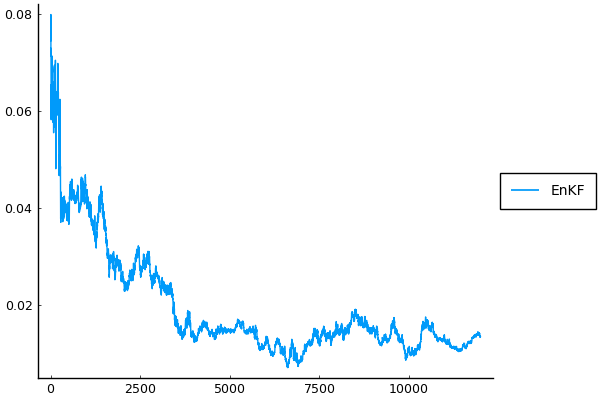

In [20]:
# Ne = 50
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)), label = "EnKF", legend = :outerright)
# plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)), label = "Low rank")
# savefig("RMSE_time_history_Ne_40.pdf")

In [277]:
rmse_lowrankenkf = mean(norm.(eachcol(mean_hist(Xalowrank)-data.xt))[10000:end]/sqrt(size(data.x0,1)))

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(21), Base.OneTo(12001)), b has dims (Base.OneTo(18), Base.OneTo(12001)), mismatch at 1")

In [278]:
rmse_enkf = mean(norm.(eachcol(mean_hist(Xa)-data.xt))[10000:end]/sqrt(size(data.x0,1)))

0.8890683217815732

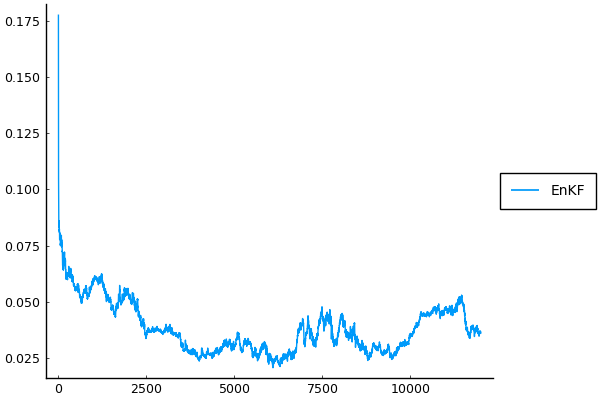

In [374]:
# Ne = 40
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)), label = "EnKF", legend = :outerright)
# plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)), label = "Low rank")
# savefig("RMSE_time_history_Ne_40.pdf")

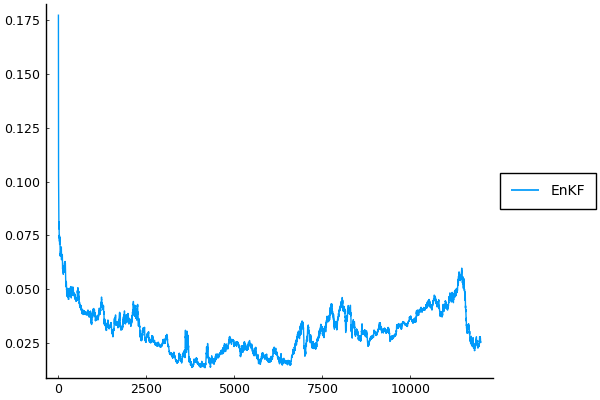

In [372]:
# Ne = 40
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)), label = "EnKF", legend = :outerright)
# plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)), label = "Low rank")
# savefig("RMSE_time_history_Ne_40.pdf")

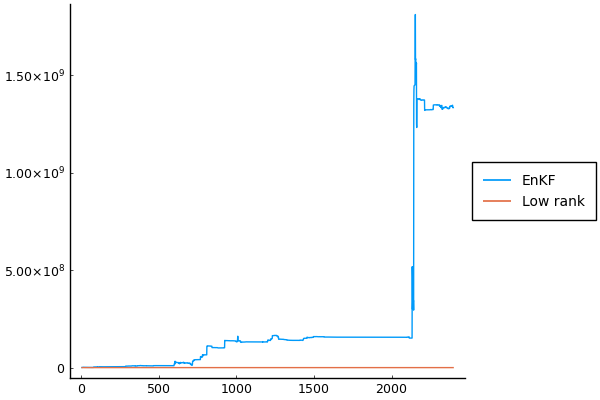

In [133]:
# Ne = 200
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)), label = "EnKF", legend = :outerright)
plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)), label = "Low rank")
# savefig("RMSE_time_history_Ne_20.pdf")

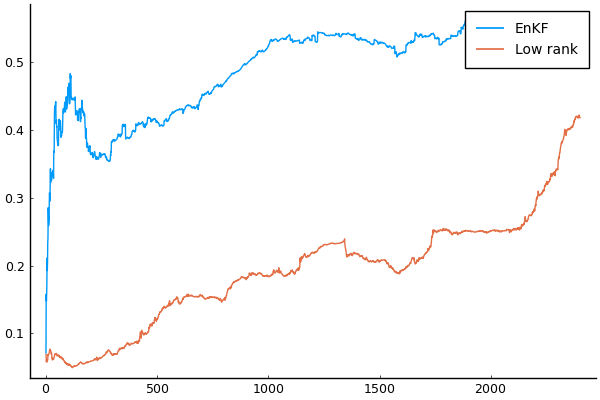

In [111]:
# Ne = 200
plot(norm.(eachcol(mean_hist(Xa)-data.xt))/sqrt(size(data.x0,1)), label = "EnKF")
plot!(norm.(eachcol(mean_hist(Xalowrank)-data.xt))/sqrt(size(data.x0,1)), label = "Low rank")
# savefig("RMSE_time_history_Ne_200.pdf")

In [386]:
Xtmp = deepcopy(Xf[end])
ϵx = RecipeInflation([config.ϵX; config.ϵΓ; config.ϵQ])
ϵmul = MultiplicativeInflation(config.β)

ϵmul(Xtmp, 1, Nx)
for i=1:Ne
    ϵx(view(Xtmp,:,i))
end
Y = hcat(map(i->measure_state(Xtmp[:,i], tf, config), 1:Ne)...)

LoadError: MethodError: no method matching (::RecipeInflation)(::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true})
[0mClosest candidates are:
[0m  (::RecipeInflation)(::AbstractVector{Float64}, [91m::VortexConfig[39m) at /media/mat/HDD/ToyVortex.jl/src/assimilation.jl:43
[0m  (::RecipeInflation)(::Any, [91m::Any[39m, [91m::Any[39m, [91m::VortexConfig[39m) at /media/mat/HDD/ToyVortex.jl/src/assimilation.jl:25

In [387]:
density(transform(Y[4:4,:])[1,:])
plot!(-4.0:0.01:4.0, map(x->1/sqrt(2*π)*exp(-0.5*x^2), -4.0:0.01:4.0))

LoadError: UndefVarError: Y not defined

In [156]:
# Ne_tab = [20; 50; 80; 100]
Nrun = 1
Nrunenkf = 20

# for Ne_i in Ne_tab
Ne_i = 40
    
rmse_lowrankenkf_tab = zeros(min(20,Nx), Ny, Nrun)
rmse_enkf_tab = zeros(Nrunenkf)

X0 = zeros(Ny+Nx, Ne_i)
X0[Ny+1:Ny+Nx,:] .= data.x0
ϵ0(X0, Ny, Nx)
@show "low-rank"
Threads.@threads for i=1:min(20, Nx)
    for j=1:Ny
        for k=1:1
            @show i,j,k
            Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; 
                                                      rxdefault = i, rydefault = j)
            rmse_lowrankenkf_tab[i,j,k] = deepcopy(norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1)))
        end
    end
    save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_lowrankenkf_Ne_"*string(Ne_i)*".jld", 
     "rmse_tab", rmse_lowrankenkf_tab)
end
save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_lowrankenkf_Ne_"*string(Ne_i)*".jld", 
     "rmse_tab", rmse_lowrankenkf_tab)

@show "full-rank"

for k=1:Nrunenkf
    @show k
    Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data)                                          
    rmse_enkf_tab[k] = deepcopy(norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1)))
end

save("/media/mat/HDD/ToyVortex.jl/notebooks/results/rmse_enkf_Ne_"*string(Ne_i)*".jld", 
     "rmse_tab", rmse_enkf_tab)
# end 

"low-rank" = "low-rank"
(i, j, k) = (9, 1, 1)
(i, j, k) = (1, 1, 1)
(i, j, k) = (5, 1, 1)
(i, j, k) = (13, 1, 1)


LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1mgetproperty[22m
    [90m   @ [39m[90m./[39m[90;4mBase.jl:33[0m[90m [inlined][39m
     [2] [0m[1manalytical_jacobian_position![22m[0m[1m([22m[90mdpdz[39m::[0mMatrix[90m{ComplexF64}[39m, [90mdpdzstar[39m::[0mMatrix[90m{ComplexF64}[39m, [90mCss[39m::[0mMatrix[90m{ComplexF64}[39m, [90m∂Css[39m::[0mMatrix[90m{Float64}[39m, [90mCts[39m::[0mMatrix[90m{ComplexF64}[39m, [90mCtsblob[39m::[0mMatrix[90m{ComplexF64}[39m, [90m∂Ctsblob[39m::[0mMatrix[90m{Float64}[39m, [90mwtarget[39m::[0mVector[90m{ComplexF64}[39m, [90mtarget[39m::[0mVector[90m{ComplexF64}[39m, [90msource[39m::[0mVector[90m{PotentialFlow.Blobs.Blob{S, Float64} where S<:Number}[39m, [90mfreestream[39m::[0mFreestream, [90mt[39m::[0mFloat64; [90miscauchystored[39m::[0mBool, [90missourcefixed[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mToyVortex[39m [90m/media/mat/HDD/ToyVortex.jl/src/[39m[90;4manalytical_pressure.jl:397[0m
     [3] [0m[1manalytical_jacobian_pressure[22m[0m[1m([22m[90mtarget[39m::[0mVector[90m{ComplexF64}[39m, [90msource[39m::[0mTuple[90m{Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}, Vector{PotentialFlow.Blobs.Blob{ComplexF64, Float64}}}[39m, [90mfreestream[39m::[0mFreestream, [90mt[39m::[0mFloat64; [90missourcefixed[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[35mToyVortex[39m [90m/media/mat/HDD/ToyVortex.jl/src/[39m[90;4manalytical_pressure.jl:625[0m
     [4] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m/media/mat/HDD/ToyVortex.jl/src/[39m[90;4mlowrankassimilation.jl:90[0m[90m [inlined][39m
     [5] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m~/.julia/packages/ProgressMeter/Vf8un/src/[39m[90;4mProgressMeter.jl:940[0m[90m [inlined][39m
     [6] [0m[1mlowrankvortexassim[22m[0m[1m([22m[90malgo[39m::[0mStochEnKF, [90mX[39m::[0mMatrix[90m{Float64}[39m, [90mtspan[39m::[0mTuple[90m{Float64, Float64}[39m, [90mconfig[39m::[0mVortexConfig, [90mdata[39m::[0mSyntheticData; [90mrxdefault[39m::[0mInt64, [90mrydefault[39m::[0mInt64[0m[1m)[22m
    [90m   @ [39m[35mToyVortex[39m [90m/media/mat/HDD/ToyVortex.jl/src/[39m[90;4mlowrankassimilation.jl:49[0m
     [7] [0m[1mmacro expansion[22m
    [90m   @ [39m[90m./[39m[90;4mIn[156]:19[0m[90m [inlined][39m
     [8] [0m[1m(::var"#702#threadsfor_fun#23"{UnitRange{Int64}})[22m[0m[1m([22m[90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:81[0m
     [9] [0m[1m(::var"#702#threadsfor_fun#23"{UnitRange{Int64}})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @ [39m[36mMain[39m [90m./[39m[90;4mthreadingconstructs.jl:48[0m

Progress:   4%|█▊                                       |  ETA: 0:03:46Progress:   1%|▎                                        |  ETA: 0:05:16Progress:   0%|                                         |  ETA: 0:04:54Progress:   0%|▏                                        |  ETA: 0:05:36Progress:   2%|▊                                        |  ETA: 0:04:35

In [46]:
median(rmse_lowrakenkf_tab)

LoadError: UndefVarError: rmse_lowrankenkf_tab not defined

In [174]:
nrun_enkf = 10
rmse_enkf_tab = zeros(nrun_enkf)

for i=1:nrun_enkf
    Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data);
    rmse_enkf = norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1))
    rmse_enkf_tab[i] = copy(rmse_enkf)
    @show i, rmse_enkf
end

Progress:  99%|████████████████████████████████████████▍|  ETA: 0:00:01

LoadError: InterruptException:

In [175]:
median(rmse_enkf_tab)

0.0

In [176]:
quantile(rmse_enkf_tab, 0.75) - quantile(rmse_enkf_tab, 0.25)

0.0

In [33]:
Cx = zeros(Nx, Nx)
Cy = zeros(Ny, Ny)

Xcxcy = deepcopy(vcat(zeros(Ny, Ne), Xf[12001]))

ϵX = config.ϵX
ϵΓ = config.ϵΓ
ϵQ = config.ϵQ
β = config.β
ϵY = config.ϵY

ϵx = RecipeInflation([ϵX; ϵΓ; ϵQ])
ϵmul = MultiplicativeInflation(β)

# Perform state inflation
ϵmul(Xcxcy, Ny+1, Ny+Nx)
ϵx(Xcxcy, Ny, Nx, config)
Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
# Dx = I
Dϵ = config.ϵY*I
# Dϵ = I
@time @inbounds for i=1:Ne
    
    J = analytical_jacobian_pressure(config.ss, state_to_lagrange(Xcxcy[Ny+1:end,i], config.zs, config), 
                                     freestream, tf; issourcefixed = true)
    Ji = J[:,vcat(collect(1:3*config.Nv), collect(6*config.Nv+1:6*config.Nv+config.Ns))]
    Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
    Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'

end

  0.026346 seconds (36.11 k allocations: 8.306 MiB, 75.85% compilation time)


In [34]:
transform(Xalowrank[401][5:5,:])

1×50 Matrix{Float64}:
 0.554115  1.61737  1.6291  2.20243  …  1.19732  -0.363603  -1.01811

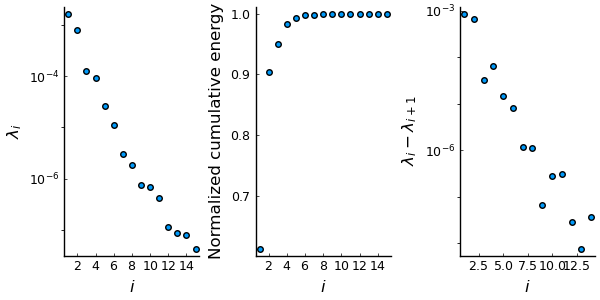

In [35]:
routine_spectrum(svd(Symmetric(Cx)).S)

In [36]:
routine_spectrum(svd(Symmetric(Cy)).S)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/mat/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Axis limits cannot be NaN or Inf')
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3849, in set_ylim
    top = self._validate_converted_limits(top, self.convert_yunits)
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3439, in _validate_converted_limits
    raise ValueError("Axis limits cannot be NaN or Inf")


In [18]:
# mean_rmse_lowrankenkf = 0.0
# nrun_lowrankenkf = 10

# for i=1:nrun_lowrankenkf
#     Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = 2, rydefault = Ny);
#     rmse_lowrankenkf = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))  
#     mean_rmse_lowrankenkf += (1/nrun_lowrankenkf)*rmse_lowrankenkf
#     @show rmse_lowrankenkf
# end

# mean_rmse_lowrankenkf

In [19]:
mean_rmse_lowrankenkf

LoadError: UndefVarError: mean_rmse_lowrankenkf not defined

In [ ]:
mean_rmse_enkf = 0.0
nrun_enkf = 10
for i=1:nrun_enkf
    Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan, config, data);
    rmse_enkf = norm(mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1))
    mean_rmse_enkf += (1/nrun_enkf)*rmse_enkf
    @show rmse_enkf
end
mean_rmse_enkf

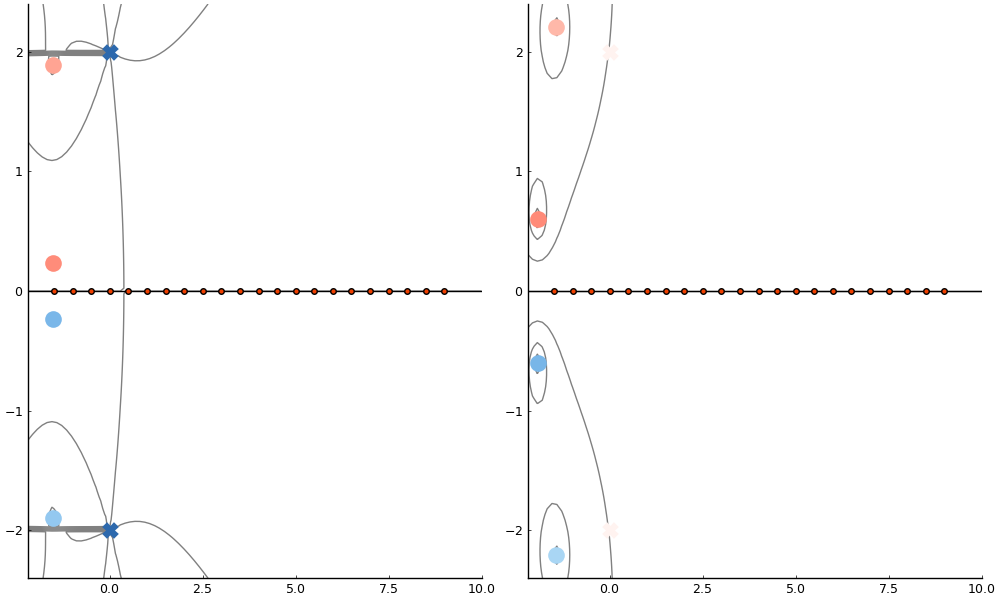

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [210]:
plt1 = routine_plot(data.xt[:,301], config, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(mean(Xa[301]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plot(plt1, plt2, size = (1000, 600))

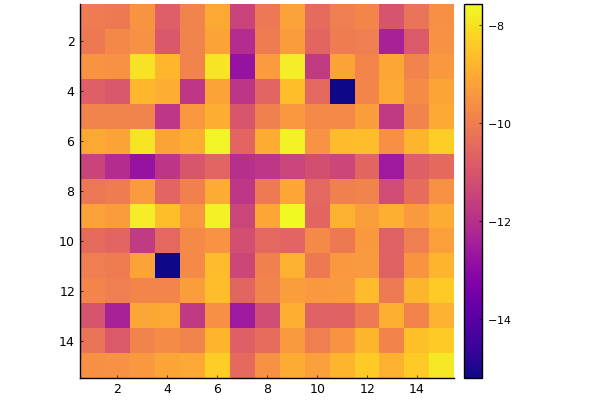

In [37]:
heatmap(1:Nx, 1:Nx, log.(abs.(Cx)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

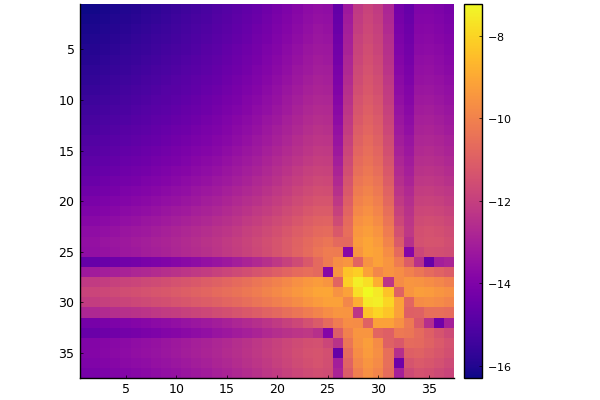

In [38]:
heatmap(log.(abs.(Cy)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

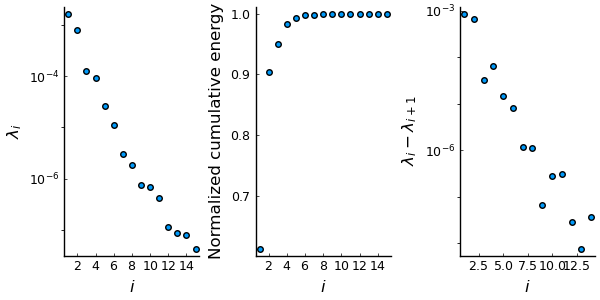

In [39]:
routine_spectrum(svd(Symmetric(Cx)).S)

In [40]:
routine_spectrum(svd(Symmetric(Cy)).S)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/mat/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Axis limits cannot be NaN or Inf')
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3849, in set_ylim
    top = self._validate_converted_limits(top, self.convert_yunits)
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3439, in _validate_converted_limits
    raise ValueError("Axis limits cannot be NaN or Inf")


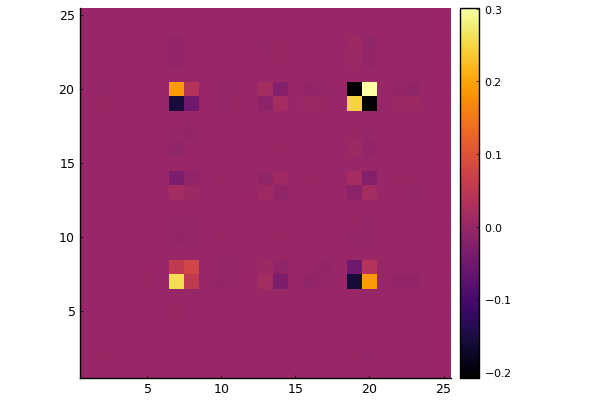

In [369]:
heatmap(cov(Xa[end]'), ratio = 1)

In [371]:
function testrun(N)
    rmse_tab = zeros(N, Nx)
    Ncount = 0
    @inbounds for i=1:N
        for j=1:Nx
            Ncount += 1
            Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = j, rydefault = Ny)
            rmse_tmp = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))
            rmse_tab[i,j] = deepcopy(rmse_tmp)
            @show i, j, rmse_tmp
        end  
    end

    return rmse_tab
end

testrun (generic function with 1 method)

In [372]:
Nrun = 1
rmse_tab = testrun(Nrun)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


(i, j, rmse_tmp) = (1, 1, 1.7797774470103498)


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:02

LoadError: InterruptException:

In [359]:
plot(rmse_tab[1,:])

LoadError: UndefVarError: rmse_tab not defined

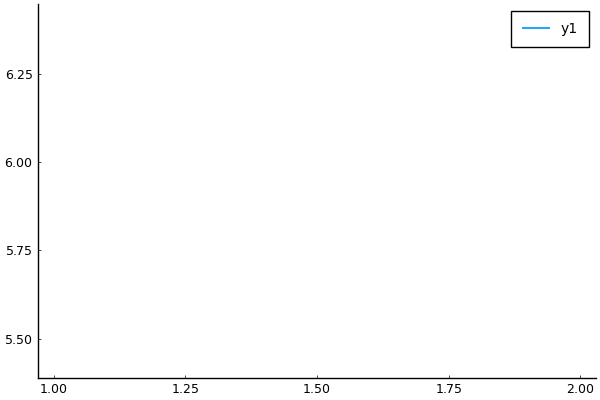

In [176]:
plot(median(rmse_tab; dims = 2)[:,1])

In [ ]:
Ne_tab = [20; 50; 70; 100; 120; 150; 200; 500]
Nrun = 10
@inbounds for Ne_tmp in Ne_tab
    @show Ne_tmp
    X0 = zeros(Ny+Nx, Ne_tmp)
    X0[Ny+1:Ny+Nx,:] .= deepcopy(data.x0)
    ϵ0(X0, Ny, Nx)
    rmse_tab = zeros(Nrun, Nx)
    for i=1:Nrun
        for j=1:Nx
            Xflowrank, Xalowrank = lowrankvortexassim(enkf, deepcopy(X0), tspan, config, data; rxdefault = j, rydefault = Ny)
            rmse_i = norm(mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1))
            rmse_tab[i,j] = deepcopy(rmse_i)
        end  
    end
    save("rmse_Nrun_"*string(Nrun)*"_Ne_"*string(Ne_tmp)*".jld", "rmse", deepcopy(rmse_tab))
end 

Ne_tmp = 20


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 50


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 70


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 100


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 

Ne_tmp = 120


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 

In [178]:
# Plot with rescaling and Cx and Cy
plt = plot(layout = grid(1, 2))
plot!(plt[1,1], 1:Nx, rmse_tab, xlabel = "rank "*latexstring("r_X"), ylabel = "RMSE", 
      label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf), legend = :outertop)
hline!(plt[1,1], [rmse_tab[end]], label = "full rank")
plot!(plt[1,2], 1:Nx, rmse_tab, yscale = :log10, xlabel = "rank "*latexstring("r_x"), 
      ylabel = "RMSE", label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf))
hline!(plt[1,2], [rmse_tab[end]], label = "full rank", legend = :outertop)
# savefig("plot_rmse_rank3.pdf")

LoadError: Expects 25 elements in each col of y, found 1.

In [179]:
# Plot without rescaling and without Cy

plt = plot(layout = grid(1, 2))
plot!(plt[1,1], 1:Nx, rmse_tab, xlabel = "rank "*latexstring("r_X"), ylabel = "RMSE", 
      label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf), legend = :outertop)
hline!(plt[1,1], [rmse_tab[end]], label = "full rank")
plot!(plt[1,2], 1:Nx, rmse_tab, yscale = :log10, xlabel = "rank "*latexstring("r_x"), 
      ylabel = "RMSE", label = "rank-"*latexstring("r_X")*" approximation", xlim = (-Inf,Inf))
hline!(plt[1,2], [rmse_tab[end]], label = "full rank", legend = :outertop)
# savefig("plot_rmse_rank2.pdf")

LoadError: Expects 25 elements in each col of y, found 1.

In [360]:
plot(norm.(eachcol((mean_hist(Xalowrank)-data.xt)/sqrt(size(data.x0,1)))))
plot!(norm.(eachcol((mean_hist(Xa)-data.xt)/sqrt(size(data.x0,1)))))

LoadError: DimensionMismatch("dimensions must match: a has dims (Base.OneTo(31), Base.OneTo(401)), b has dims (Base.OneTo(25), Base.OneTo(401)), mismatch at 1")

In [168]:
100*(rmse_enkf - rmse_lowrankenkf)/rmse_enkf

-40.125336922503585

In [373]:
cumsum(svd(Symmetric(Cx)).S) ./ sum(svd(Symmetric(Cx)).S)

25-element Vector{Float64}:
 0.6619888437926841
 0.8477771243603104
 0.9458249324887349
 0.9744949568364281
 0.9863407313059299
 0.9967358800745958
 0.9983973706029737
 0.999333008538623
 0.999791200039511
 0.9998522069254409
 0.9999048221933542
 0.99994073200833
 0.9999636645808224
 0.9999800540428886
 0.9999918298456081
 0.9999989618545169
 0.9999996382120458
 0.9999997782542481
 0.999999862390587
 0.999999940627871
 0.9999999660193148
 0.9999999860680941
 0.9999999951155185
 0.9999999995138837
 1.0

In [374]:
cumsum(svd(Symmetric(Cy)).S) ./ sum(svd(Symmetric(Cy)).S)

9-element Vector{Float64}:
 0.7838785290239051
 0.986489919245771
 0.99914452425824
 0.9999758626542511
 0.9999996256524059
 0.9999999725346367
 0.9999999995530325
 0.9999999999999486
 0.9999999999999999

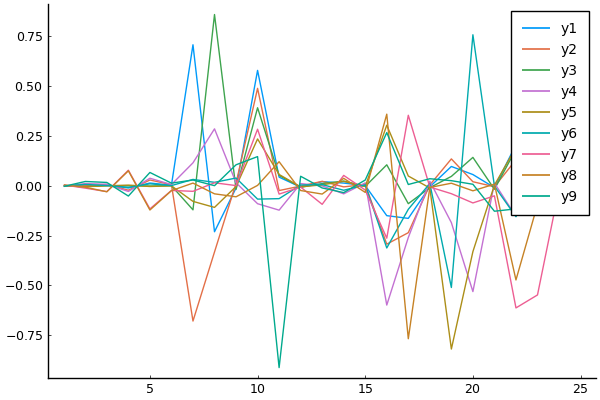

In [375]:
plot(svd(Symmetric(Cx)).U[:,1:9])

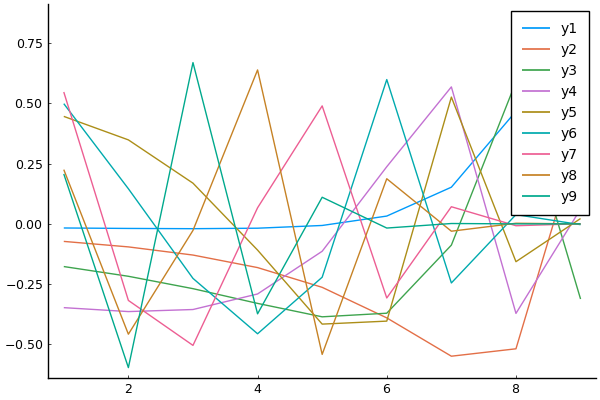

In [376]:
plot(svd(Symmetric(Cy)).U[:,1:9])

In [80]:
routine_plotCx(mean(Xa[101]; dims= 2)[:,1], Cx, 4, config, xgrid, ygrid; withvortices = true)

LoadError: UndefVarError: Cx not defined

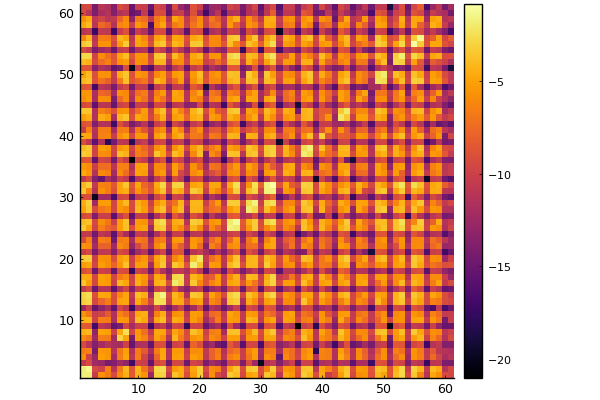

In [105]:
heatmap(log.(abs.(cov(Xalowrank[401]'))), ratio = 1)

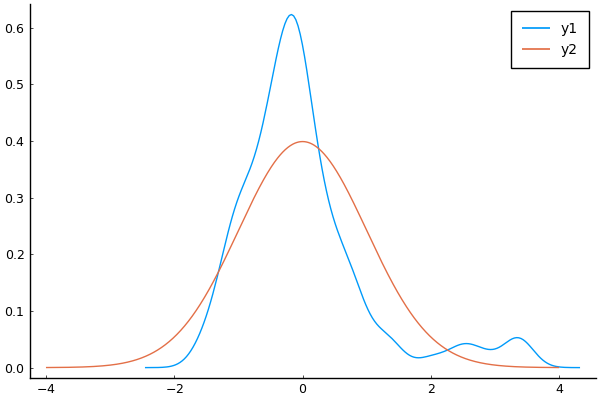

In [108]:
density(transform(Xalowrank[401][4:4,:])[1,:])
plot!(-4.0:0.01:4.0, map(x->1/sqrt(2*π)*exp(-0.5*x^2), -4.0:0.01:4.0))

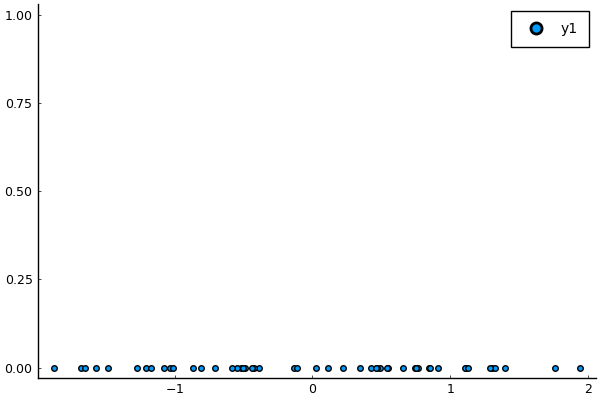

In [380]:
scatter(transform(Xalowrank[201][9:9,:])[1,:], zeros(Ne))

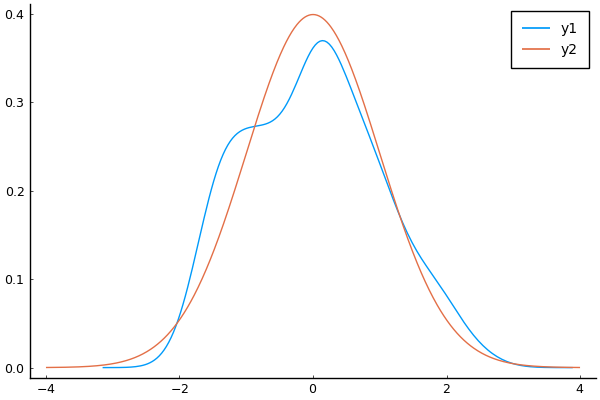

In [79]:
idx = 2
density(transform(Xa[11][idx:idx,:])[1,:])
# density!(transform(Xalowrank[401][9:9,:])[1,:])
plot!(-4.0:0.01:4.0, map(x->1/sqrt(2*π)*exp(-0.5*x^2), -4.0:0.01:4.0))

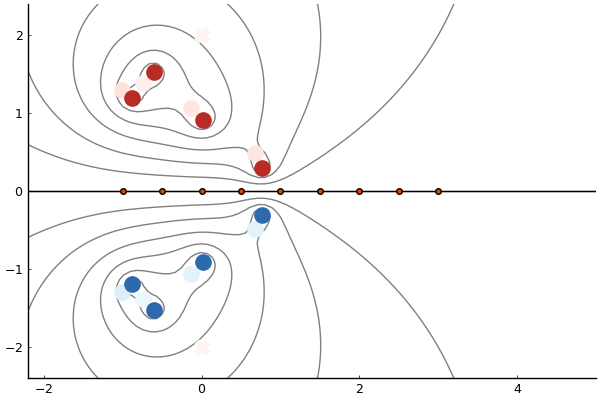

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [382]:
routine_plot(mean(Xa[101]; dims= 2)[:,1], config, xgrid, ygrid; withvortices = true)

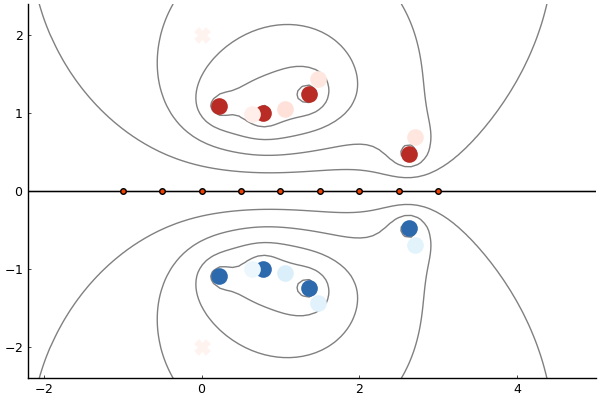

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [385]:
plt = plot(layout = grid(1,2))
routine_plot(mean(Xalowrank[201]; dims= 2)[:,1], config, xgrid, ygrid; withvortices = true)

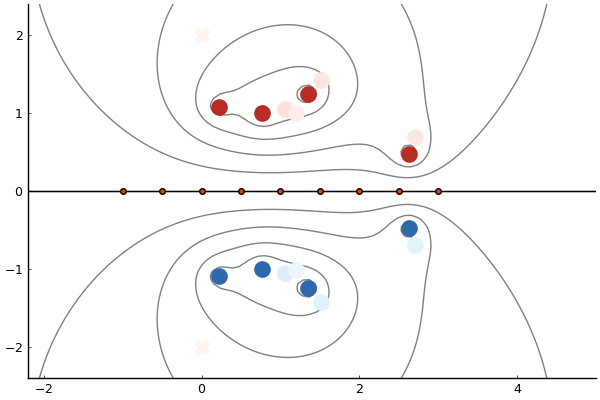

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [386]:
routine_plot(data.xt[:,201], config, xgrid, ygrid; withvortices = true)

In [271]:
maximum(Xalowrank[end])

4.226257652563084

In [254]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config.Δt)+1
    
#     Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
# #     plt1 = routine_plot(data.xt[:,nsnap], config, xgrid, ygrid)
#     plt2 = routine_plot(mean(Xalowrank[nsnap]; dims = 2)[:,1], config, xgrid, ygrid)
#     plt3 = plot(xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), legend = false, xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot!(plt3, real(config.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config), 
#           linewidth = 2, color = :navyblue)
#     plot!(plt3, real(config.ss), 2*mean(Ysnap; dims = 2)[:,1],
#           linewdith = 2, color = :orangered, linestyle = :dash, ribbon = 2*std(Ysnap; dims = 2)[:,1])
#     plot(plt2, plt3)
#     next!(prog)
# end

In [273]:
maximum(vcat(Xalowrank...))

4.226257652563084

In [253]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config.Δt)+1
    
#     Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
#     plt1 = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
#     plt2 = plot(xlim = (-Inf, Inf), 
#                 linewidth = 2, ylim = (-4.0, 0.0), xlabel = L"x", ylabel = L"p / 0.5 \rho U^2")
#     plot!(plt2, real(config.ss), 2*measure_state(data.xt[:,nsnap], tsnap, config), 
#           linewidth = 2, color = :navyblue, label = "Truth")
#     plot!(plt2, real(config.ss), 2*mean(Ysnap; dims = 2)[:,1],
#           linewdith = 2, color = :orangered, linestyle = :dash, ribbon = 2*std(Ysnap; dims = 2)[:,1], label = "EnKF")
#     plot(plt1, plt2)
#     next!(prog)
# end

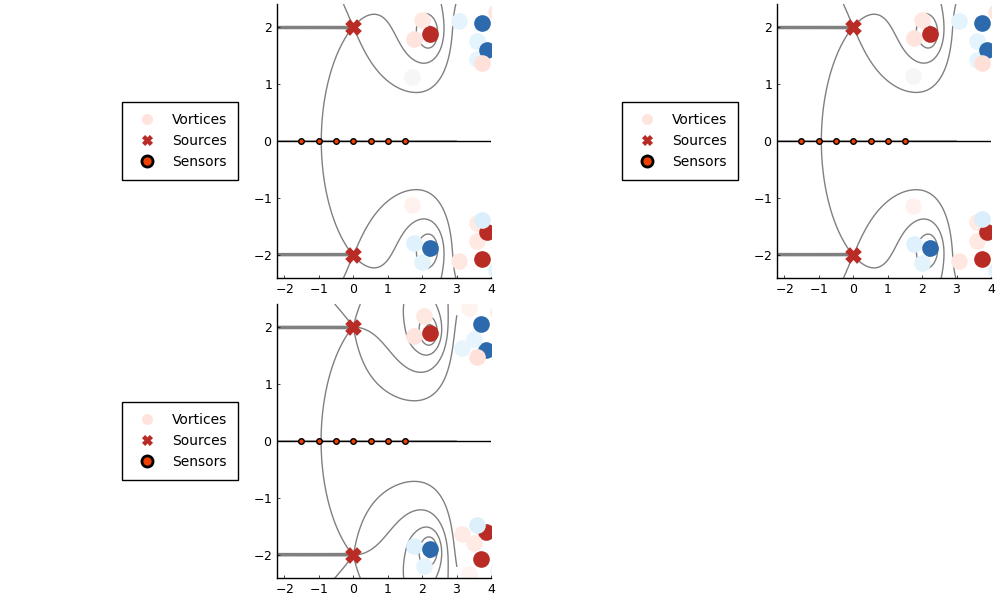

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [275]:
plt1 = routine_plot(data.xt[:,401], config, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(mean(Xa[401]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plt3 = routine_plot(mean(Xalowrank[401]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
plot(plt1, plt2, plt3, size = (1000, 600))

In [255]:
# prog = Progress(length(t0:Δtgif:tf))

# @gif for tsnap in t0:Δtgif:tf
#     nsnap = ceil(Int64, tsnap/config.Δt)+1
    
#     Ysnap = hcat(map(xi -> measure_state(xi, 1.0, config), eachcol(Xa[nsnap]))...)
#     plt1 = routine_plot(data.xt[:,nsnap], config, xgrid, ygrid; withvortices = true)
#     plt2 = routine_plot(mean(Xa[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)
#     plt3 = routine_plot(mean(Xalowrank[nsnap]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)

#     plot(plt1, plt2, plt3)
#     next!(prog)
# end

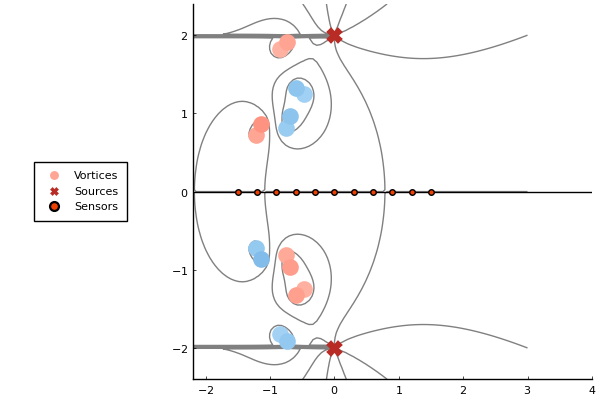

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [93]:
routine_plot(mean(Xa[101]; dims = 2)[:,1], config, xgrid, ygrid; withvortices = true)

In [178]:
measure_state(data.xt[:,end], tf, config)-measure_state(mean(Xa[end]; dims = 2)[:,1], tf, config)

14-element Vector{Float64}:
 -0.0011000356557158142
 -0.0011860747784697145
 -0.0012771207647282456
 -0.0013722130283266298
 -0.0014709931164431644
 -0.001575197338241796
 -0.0016904663639493722
 -0.0018271489445737532
 -0.001998868911010754
 -0.002219917575396413
 -0.0025056555954941495
 -0.002883167366943107
 -0.0034283646269996915
 -0.004367460328834616

In [179]:
map(xi-> measure_state(xi, tf, config), eachcol(Xa[end]))[1]

14-element Vector{Float64}:
 -0.4807215752386348
 -0.47872728766790523
 -0.47641499344182936
 -0.47371708741895213
 -0.47055033441545585
 -0.46681345065072644
 -0.4623843272914594
 -0.45711574747640155
 -0.4508296347355466
 -0.4433152775545013
 -0.4343469075408013
 -0.42375431954638065
 -0.4116284182156947
 -0.39888358088778775

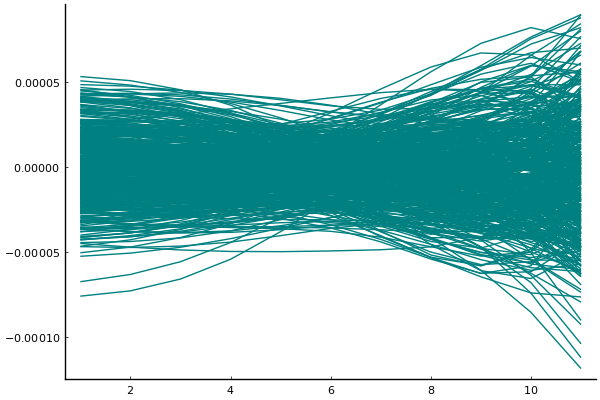

In [96]:
plot(map(xi-> measure_state(xi, tf, config)  - measure_state(mean(Xa[end]; dims=2)[:,1], tf, config), 
        eachcol(Xa[end])),
        color = :teal, linewdith = 2, legend = false)
# plot!(measure_state(data.xt[:,end], tf, config), linewidth = 2,
#       color = :orangered2, linestyle = :dash)

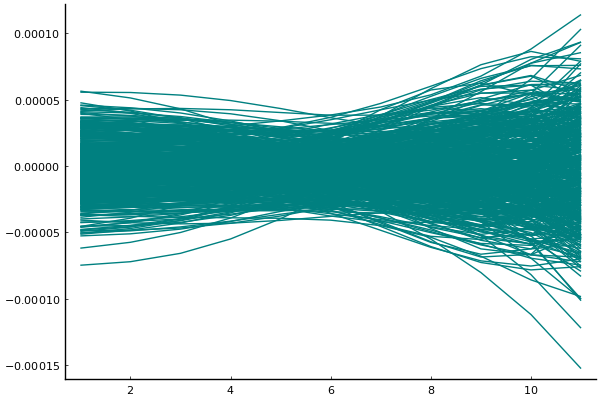

In [97]:
plot(map(xi-> measure_state(xi, tf, config)  - measure_state(mean(Xf[end]; dims=2)[:,1], tf, config), 
        eachcol(Xf[end])),
        color = :teal, linewdith = 2, legend = false)

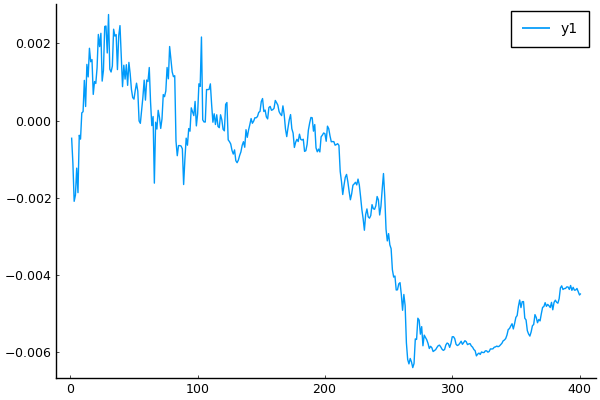

In [177]:
plot(hcat(mean.(Xalowrank; dims = 2)...)[end,:])

In [99]:
J = jacobian_pressure(config.ss, state_to_lagrange(Xa[end][:,1], config.zs, config), freestream, tf)

11×50 Matrix{Float64}:
 -0.00536145  0.00205991   0.000112305  …   0.0368174    0.0368174
 -0.00639636  0.00255385   0.000215395      0.0344128    0.0344128
 -0.00767256  0.00317286   0.000281816      0.0299923    0.0299923
 -0.00923541  0.00395668   0.000274169      0.0230978    0.0230978
 -0.0111257   0.00496496   0.000164268      0.0136464    0.0136464
 -0.0133621   0.00628038  -2.92156e-5   …   0.00224315   0.00224315
 -0.0158905   0.0079871   -0.000190207     -0.00977374  -0.00977374
 -0.0184551   0.0100861   -5.74489e-5      -0.0207658   -0.0207658
 -0.0203482   0.0122953    0.000813784     -0.0294591   -0.0294591
 -0.0201104   0.0137285    0.00306654      -0.035333    -0.035333
 -0.015625    0.0127493    0.00740562   …  -0.0385594   -0.0385594

In [110]:
 cumsum(svd(Symmetric(Cx)).S)./sum(svd(Symmetric(Cx)).S)

25-element Vector{Float64}:
 0.6681933665414967
 0.9160547060782901
 0.9785203974384282
 0.9969743624810625
 0.998975448878397
 0.9993131131933654
 0.9995550600421969
 0.9996629041135013
 0.9997512839474035
 0.9998143491994708
 0.999860559873983
 0.9998957771067523
 0.9999211007719049
 0.9999386708140486
 0.9999539200548163
 0.9999667007110551
 0.9999771784956322
 0.999983822537578
 0.9999894316407507
 0.9999925475543354
 0.9999950055088012
 0.999996752715211
 0.9999979315653077
 0.9999990336635767
 0.9999999999999999